In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from sklearn.metrics import r2_score
import pickle

# Carrega o .csv
df = pd.read_csv('teste_indicium_precificacao.csv')

#Armazena o número total de linhas do dataset original. Essa informação será usada mais tarde
df_linhas_original = len(df)

In [2]:
# Verifica anúncios duplicados

df['id'].duplicated().sum()

0

Como o valor de ID´s duplicados é zero pode-se concluir que não há anúncios duplicados

In [3]:
#Identifica os valores null
df.isnull().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

A coluna 'host_name' possue valores nulos, mas como não serão utilizadas na análise elas podem ser excluídas

As colunas 'ultima_review' e 'reviews_por_mes' possuem valores nulos que serão subtituidos pela mediana no passo abaixo

In [4]:
df['reviews_por_mes'] = df['reviews_por_mes'].fillna(df['reviews_por_mes'].median())
df['disponibilidade_365'] = df['disponibilidade_365'].fillna(df['disponibilidade_365'].median())

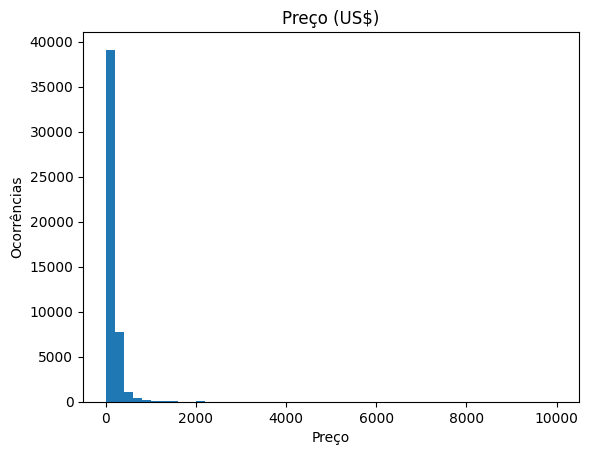

In [5]:
# Identificação de Outliers 1 - PREÇO
plt.hist(df['price'], bins=50)
plt.title("Preço (US$)")
plt.xlabel('Preço')
plt.ylabel('Ocorrências')
plt.show()

Como os valores de preço de concentram na faixa de mil dólares vamos utilizar esse valor como filtro para eliminar parte dos outliers

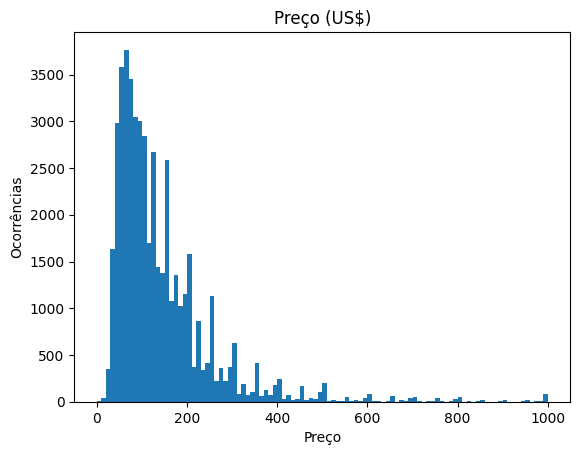

In [6]:
# Identificação de Outliers 1.1 - PREÇO

df = df[df['price']<=1000]

plt.hist(df['price'], bins=100)
plt.title("Preço (US$)")
plt.xlabel('Preço')
plt.ylabel('Ocorrências')
plt.show()

No gráfico anterior fica evidente que os principais preços estão abaixo de 600 dólares, portanto iremos adotar esse valor como referência para eliminar os outliers de preço.

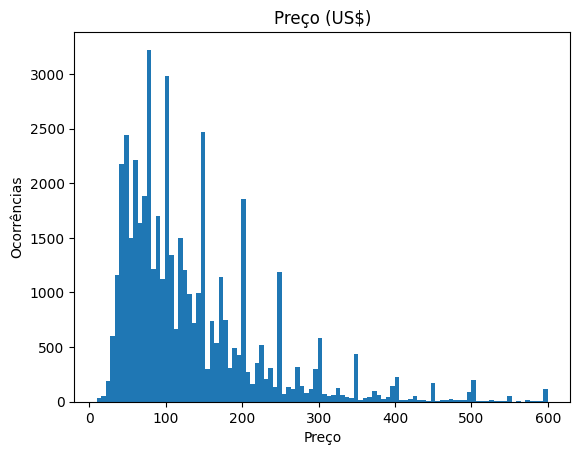

In [7]:
# Identificação de Outliers 1.2 - "PREÇO"

#aplicação de filtro
df = df[(df['price']<=600) & (df['price']!=0)]

plt.hist(df['price'], bins=100)
plt.title("Preço (US$)")
plt.xlabel('Preço')
plt.ylabel('Ocorrências')
plt.show()

In [8]:
#Identificação de Outliers 2 - "MÍNIMO DE NOITES"

print(f"O mínimo de noites é de {df['minimo_noites'].min()} dia(s)")
print(f"O máximo de noites é de {df['minimo_noites'].max()} dia(s) \n")

O mínimo de noites é de 1 dia(s)
O máximo de noites é de 1250 dia(s) 



Os dados acima mostram que há pelo menos um anúncio em que o número mínimo de noite é 1250 noites!!!!
Como esse valor é absurdamente alto vamos filtra-lo para um valor mais compativel com a setor de hospedagem. O valor máximo será de 30 dias.

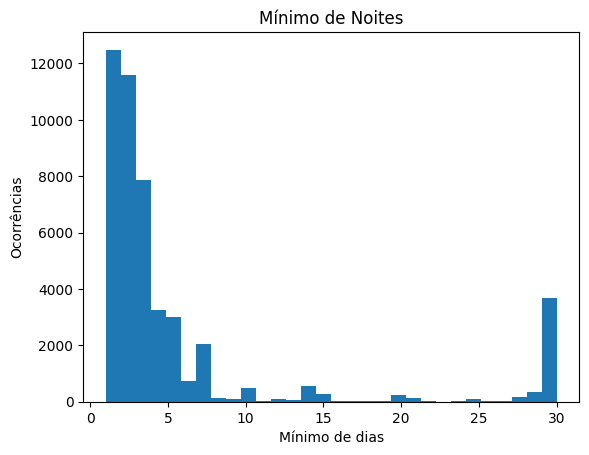

In [9]:
#Identificação de Outliers - "MÍNIMO DE NOITES" 2.1

#Aplicação de filtro
df = df[df['minimo_noites']<=30]

plt.hist(df['minimo_noites'],bins=30)
plt.xlabel('Mínimo de dias')
plt.ylabel('Ocorrências')
plt.title('Mínimo de Noites')
plt.show()

A disponibilidade máxima é de 365 dias


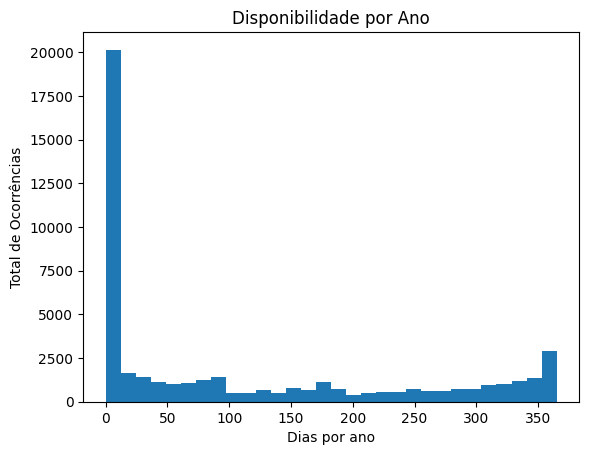

In [10]:
#Identificação de Outliers - "DISPONIBLIDADE 365"

print(f"A disponibilidade máxima é de {df['disponibilidade_365'].max()} dias")

plt.hist(df['disponibilidade_365'], bins=30)
plt.xlabel("Dias por ano")
plt.ylabel("Total de Ocorrências")
plt.title("Disponibilidade por Ano")
plt.show()

Não ha valores que excedam os 365 dias.

In [11]:
#Resultado do manuseio de dados
#Linhas removidas

número_linhas_atual = len(df)
número_linhas_removidas = df_linhas_original - len(df)

#Exibição dos dados
print(f'O número de linhas do dataframe original era de {df_linhas_original}')
print(f'O número de linhas atual é de {len(df)}')
print(f'O número de linhas removidas foi de {número_linhas_removidas}')

O número de linhas do dataframe original era de 48894
O número de linhas atual é de 47389
O número de linhas removidas foi de 1505


A "perda" de 1505 foi necessária para remover os outliers e dar mais qualidade a análise. As linhas removidas representam apenas 3,07% do dataset original.

room_type
Entire home/apt    24265
Private room       21991
Shared room         1133
Name: count, dtype: int64


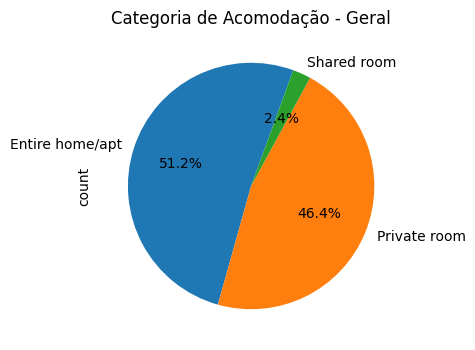

In [12]:
#Categoria de Acomodação Geral

categoria_acomodação_geral = df[['room_type']].copy()
categoria_acomodação_geral = categoria_acomodação_geral.groupby(by='room_type').value_counts()
print(categoria_acomodação_geral)

#Obs:. Gráfico criado com auxílio de IA
plt.figure(figsize=(4, 4))
categoria_acomodação_geral.plot(kind='pie', autopct='%1.1f%%', startangle=70)
plt.title('Categoria de Acomodação - Geral')
plt.show()

Há uma clara predominância de disponibilidade de quartos privativos e apartamentos completos/casa

     bairro_group        room_type  Total
0           Bronx  Entire home/apt    367
1           Bronx     Private room    647
2           Bronx      Shared room     58
3        Brooklyn  Entire home/apt   9287
4        Brooklyn     Private room  10000
5        Brooklyn      Shared room    407
6       Manhattan  Entire home/apt  12376
7       Manhattan     Private room   7824
8       Manhattan      Shared room    468
9          Queens  Entire home/apt   2067
10         Queens     Private room   3334
11         Queens      Shared room    191
12  Staten Island  Entire home/apt    168
13  Staten Island     Private room    186
14  Staten Island      Shared room      9


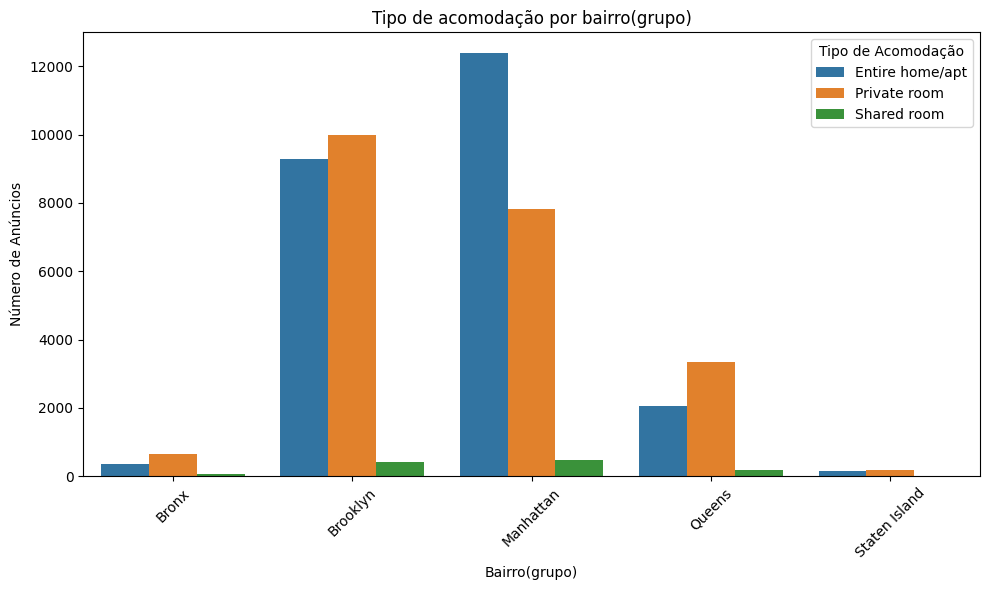

In [13]:
#Categoria de Acomodação por bairro
acomodaçâo_por_bairro = df.groupby(['bairro_group', 'room_type']).size().reset_index(name='Total')

print(acomodaçâo_por_bairro)

plt.figure(figsize=(10, 6))
sns.barplot(x='bairro_group', y='Total', hue='room_type', data=acomodaçâo_por_bairro)
plt.title('Tipo de acomodação por bairro(grupo)')
plt.xlabel('Bairro(grupo)')
plt.ylabel('Número de Anúncios')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Acomodação')
plt.tight_layout()
plt.show()

Os bairros(grupo) de Manhattan e Brooklyn concentram o número de anúncios para Nova York. Staten Island tem uma participação ínfima.

Preços por bairro (grupo) em US$
                Preço Mín. (US$)  Preço Médio (US$)  Preço Mediando (US$)  \
Bairro (grupo)                                                              
Manhattan                     10             166.91                 145.0   
Brooklyn                      10             114.37                  90.0   
Queens                        10              93.63                  75.0   
Staten Island                 13              91.43                  75.0   
Bronx                         10              82.94                  65.0   

                Preço Máx. (US$)  
Bairro (grupo)                    
Manhattan                    600  
Brooklyn                     600  
Queens                       600  
Staten Island                450  
Bronx                        600  



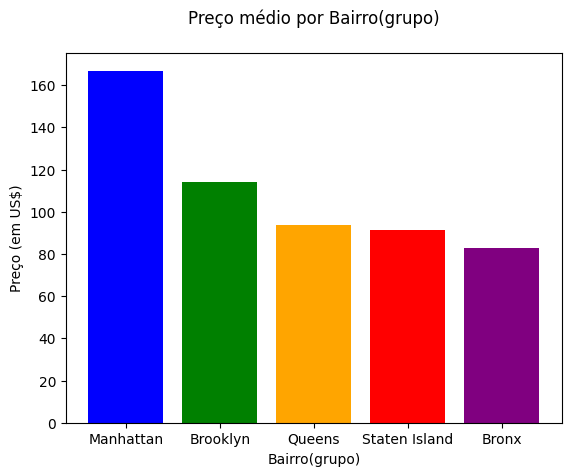

In [14]:
#Analisa os valores de preço médio por bairro(grupo)

#Seleciona as colunas desejadas
bairro_grupo = df[['bairro_group', 'price']]

#Renomeia o index
bairro_grupo = bairro_grupo.rename(columns={"bairro_group":"Bairro (grupo)"})

#Agrega o preço mínimo, médio, mediano e máximo
bairro_grupo = bairro_grupo.groupby(by='Bairro (grupo)').agg((['min','mean','median','max']))

#Arredonda o preço médio em 2 números após a vírgula
bairro_grupo[('price', 'mean')] = round(bairro_grupo[('price', 'mean')],2)



#Renomeia as colunas
bairro_grupo.columns = ['Preço Mín. (US$)','Preço Médio (US$)', 'Preço Mediando (US$)','Preço Máx. (US$)']

#Ordena pelo maior preço médio
bairro_grupo.sort_values(by='Preço Médio (US$)', inplace=True, ascending=False)

print("Preços por bairro (grupo) em US$")
print(bairro_grupo)
print("")

plt.bar(bairro_grupo.index, bairro_grupo['Preço Médio (US$)'],color=['blue', 'green', 'orange', 'red','purple'])
plt.title("Preço médio por Bairro(grupo)\n")
plt.ylabel("Preço (em US$)")
plt.xlabel("Bairro(grupo)")
plt.show()



Categoria de Acomodação por bairro(grupo)an
                                  Preço Mín. (US$)  Preço Médio (US$)  \
Bairro(grupo) Tipo de Acomodação                                        
Bronx         Entire home/apt                   28             125.04   
              Private room                      10              62.23   
              Shared room                       20              47.64   
Brooklyn      Entire home/apt                   10             163.00   
              Private room                      10              71.87   
              Shared room                       15              49.09   
Manhattan     Entire home/apt                   10             209.32   
              Private room                      10             104.77   
              Shared room                       10              84.40   
Queens        Entire home/apt                   10             140.14   
              Private room                      10              67.32   
       

<Figure size 1200x800 with 0 Axes>

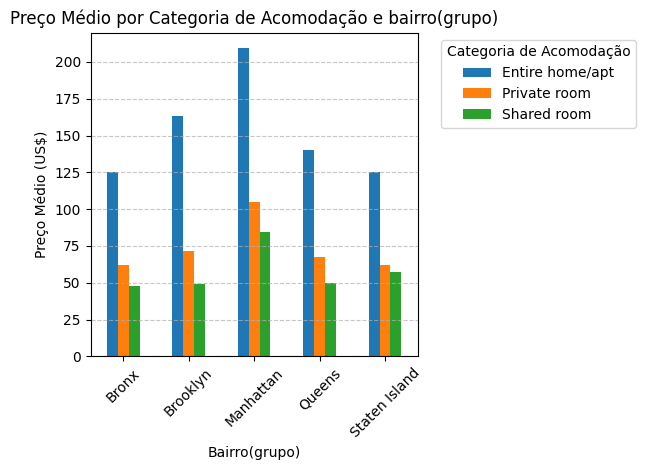

In [15]:
#5
#Preço médio por bairro(grupo) e tipo de acomodação

#Seleciona as colunas do DF
categoria_acomodação = df[['bairro_group','room_type', 'price']].copy()
categoria_acomodação.columns = ['Bairro(grupo)','Tipo de Acomodação','Média(US$)']

#Agrega o preço mínimo, médio, mediano e máximo
categoria_acomodação_por_bairro_plot = categoria_acomodação.groupby(by=['Bairro(grupo)','Tipo de Acomodação']).agg((['min','mean','median','max']))

#Renomeia as colunas
categoria_acomodação_por_bairro_plot.columns = ['Preço Mín. (US$)','Preço Médio (US$)', 'Preço Mediando (US$)','Preço Máx. (US$)']

#Arredonda o valor de preço médio para dois dígitos após a vírgula
categoria_acomodação_por_bairro_plot['Preço Médio (US$)'] = round(categoria_acomodação_por_bairro_plot['Preço Médio (US$)'],2)




#Prepara dados para o gráfico
categoria_acomodação = df[['bairro_group','room_type', 'price']].copy()
categoria_acomodação.columns = ['Bairro(grupo)','Tipo de Acomodação','Média(US$)']
categoria_acomodação = categoria_acomodação.groupby(['Bairro(grupo)', 'Tipo de Acomodação']).mean().reset_index()


#Geração do Gráfico
#OBSERVAÇÂO: código do gráfico foi gerado com auxílio de IA
plt.figure(figsize=(12, 8))
categoria_acomodação.pivot(index="Bairro(grupo)", columns="Tipo de Acomodação", values="Média(US$)").plot(kind='bar')
plt.title('Preço Médio por Categoria de Acomodação e bairro(grupo)')
plt.xlabel('Bairro(grupo)')
plt.ylabel('Preço Médio (US$)')
plt.xticks(rotation=45)
plt.legend(title='Categoria de Acomodação', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


#Exibição dos dados

print("Categoria de Acomodação por bairro(grupo)an")
print(categoria_acomodação_por_bairro_plot)
print("\n\n\n")

#Exibição do gráfico
plt.show()


Em todos os bairros(grupo) o preço do apartamento completo/casa é o maior, seguido de quarto privativo e depois de quarto compartilhado.
O preço maior do apartamento completo/casa é esperado uma vez que esses imóveis possuem vários quartos.

In [16]:
#Maiores anfitriões
#Seleciona as colunas do DF
hosts = df[['host_id','host_name','calculado_host_listings_count']].copy()

#Remove host_id duplicados
hosts.drop_duplicates(subset='host_id',inplace=True)

#Renomeia as colunas
hosts.columns = ['ID do Host','Nome do host','Total de Anúncios']

#Ordena para mostrar os anfitriões com mais anúncios
hosts.sort_values(by='Total de Anúncios', ascending=False, inplace=True)



#Bairro dos maiores anfitriões#

#Seleciona as colunas do DF
maiores_anfitriões_bairro = df[['host_id','bairro_group']].copy()
#Seleciona somente os 10 maiores hosts
maiores_anfitriões_bairro = maiores_anfitriões_bairro[maiores_anfitriões_bairro['host_id'].isin(hosts['ID do Host'][0:10])]
#Agrupa e ordena
maiores_anfitriões_bairro = maiores_anfitriões_bairro.groupby(by='bairro_group').size().sort_values(ascending=False).reset_index(name='Ocorrências')
#Aplica a %
maiores_anfitriões_bairro['%'] = maiores_anfitriões_bairro['Ocorrências'].apply(lambda x: (x / maiores_anfitriões_bairro['Ocorrências'].sum())*100)
#Aplica o arredondamento
maiores_anfitriões_bairro['%'] = round(maiores_anfitriões_bairro['%'],2)



#Acomodação dos maiores anfitriões

#Seleciona as colunas do DF
maiores_anfitriões_acomodação = df[['host_id','room_type']].copy()
#Seleciona somente os 10 maiores hosts
maiores_anfitriões_acomodação = maiores_anfitriões_acomodação[maiores_anfitriões_acomodação['host_id'].isin(hosts['ID do Host'][0:10])]
#Agrupa e ordena
maiores_anfitriões_acomodação = maiores_anfitriões_acomodação.groupby('room_type').size().sort_values(ascending=False).reset_index(name='Ocorrências')
#Renomeia as colunas
maiores_anfitriões_acomodação.columns = ['Tipo de Acomodação','Ocorrências']
#Aplica a %
maiores_anfitriões_acomodação['%'] = maiores_anfitriões_acomodação['Ocorrências'].apply(lambda x: (x / maiores_anfitriões_acomodação['Ocorrências'].sum())*100)
#Faz o arredondamento
maiores_anfitriões_acomodação['%'] = round(maiores_anfitriões_acomodação['%'],2)



#Anúncios por anfitrião
#Seleciona as colunas do DF
anúncio_por_host = df[['host_id','calculado_host_listings_count']].copy()
#Remove os hosts duplicados
anúncio_por_host.drop_duplicates('host_id',inplace=True)
#Delete a coluna do id_host
anúncio_por_host.drop(columns='host_id', inplace=True)
#Faz o agrupamento
anúncio_por_host = anúncio_por_host.groupby(by='calculado_host_listings_count').size().reset_index(name="Número de Hosts")
#Renomeia
anúncio_por_host.columns = ['Número de listings','Ocorrência']
#Aplica a %
anúncio_por_host['%'] = anúncio_por_host['Ocorrência'].apply(lambda x: (x / anúncio_por_host['Ocorrência'].sum()) * 100)
#Faz o arredondamento
anúncio_por_host['%'] = round(anúncio_por_host['%'],2)


#Exibição dos dados

#10 maiores anfitriões
print("10 maiores anfitriões")
print(hosts.head(10))

#Bairro dos maiores anfitriões
print("\n\n\nBairros das acomodações dos 10 maiores anfitriões\n")
print(maiores_anfitriões_bairro)

#Tipo de Acomodação dos maiores anfitriões
print("\nAs acomodações dos 10 maiores anfitriões\n\n")
print(maiores_anfitriões_acomodação)

#Anúncios por host
print("\n\n\nNúmero de anúncios por host\n")
print(anúncio_por_host.head(10))




10 maiores anfitriões
       ID do Host       Nome do host  Total de Anúncios
38292   219517861       Sonder (NYC)                327
26136   107434423         Blueground                232
9739     30283594               Kara                121
32717   137358866             Kazuya                103
30636    12243051             Sonder                 96
5092     16098958     Jeremy & Laura                 96
14681    61391963  Corporate Housing                 91
15864    22541573                Ken                 87
34009   200380610            Pranjal                 65
1385      1475015               Mike                 52



Bairros das acomodações dos 10 maiores anfitriões

  bairro_group  Ocorrências      %
0    Manhattan         1155  92.92
1       Queens           79   6.36
2     Brooklyn            9   0.72

As acomodações dos 10 maiores anfitriões


  Tipo de Acomodação  Ocorrências      %
0    Entire home/apt         1134  91.23
1       Private room          109   8.77



Os 10 maiores anfitriões somam 1270 anúncios.

Os 10 maiores anfitriões concentram os anúncios em Manhattan(92.92%) e Queens(6.36%)

Os 10 maiores anfitriões tem como principal tipo de acomodação o apartamento/casa(91.23%) e nenhum quarto compartilhado

A vasta maioria dos anfitriões (85.99%) tem apenas um anúncio.

In [17]:
#Disponibilidade 365

#Seleciona as colunas do DF
disponibilidade = df[['bairro_group','room_type','disponibilidade_365']].copy()


#Disponibilidade por tipo de acomodação
disponibilidade_por_tipo_acomodação = disponibilidade.groupby(by='room_type').mean(numeric_only=True)
#Faz o arredondamento
disponibilidade_por_tipo_acomodação = round(disponibilidade_por_tipo_acomodação,2)



#Disponibilidade por bairro(grupo)
disponibilidade_por_bairro = disponibilidade.groupby(by='bairro_group').mean(numeric_only=True)
disponibilidade_por_bairro = round(disponibilidade_por_bairro,2)


#Exibição de dados

print("Disponibilidade anual por tipo de acomodação\n")
print(f'{disponibilidade_por_tipo_acomodação} \n\n\n')

print("Disponibilidade anual por bairro(grupo)\n")
print(disponibilidade_por_bairro)

Disponibilidade anual por tipo de acomodação

                 disponibilidade_365
room_type                           
Entire home/apt               108.37
Private room                  110.20
Shared room                   162.31 



Disponibilidade anual por bairro(grupo)

               disponibilidade_365
bairro_group                      
Bronx                       165.55
Brooklyn                     99.01
Manhattan                   108.06
Queens                      143.83
Staten Island               198.36


O apartamento/casa e o quarto privativo são os tipo de acomodação que ficam menos tempo disponível, o que pode indicar uma procura maior.

O quarto compartilhado é que fica mais ocioso.

Os bairros(grupo) com menos tempo disponíivel são o Brooklyn e Manhattan, o que provavelmente indica uma preferência maior dos turistas.

Correlação entre Mínimo de Noites e Preço

                  Mínimo de noites  Preço Médio(US$)
Mínimo de noites          1.000000         -0.241706
Preço Médio(US$)         -0.241706          1.000000






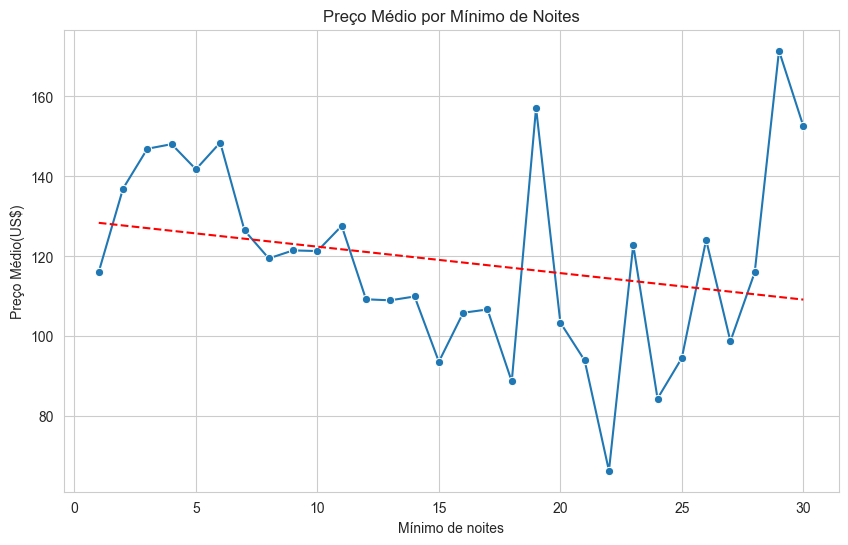

In [18]:
#Mínimo de noites e disponibilidade

#Seleciona as colunas do df
min_noite_disponibilidade = df[['minimo_noites','price']].copy()

#Faz o agrupamento
min_noite_disponibilidade = min_noite_disponibilidade.groupby(by='minimo_noites').mean().reset_index()
#Faz o arredondamento para dois números após a vírgula
min_noite_disponibilidade['price'] = round(min_noite_disponibilidade['price'],2)

#Renomeia as colunas
min_noite_disponibilidade.columns = ['Mínimo de noites','Preço Médio(US$)']

#Calcula a correlação
correlação = min_noite_disponibilidade.corr()


#Gráfico
#OBSERVAÇÃO: código de geração do gráfico foi gerado com auxílio de IA.

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.lineplot(data=min_noite_disponibilidade, x='Mínimo de noites', y='Preço Médio(US$)', marker='o', errorbar=None)

# Adicione a linha de tendência usando numpy para calcular a tendência linear
z = np.polyfit(min_noite_disponibilidade['Mínimo de noites'], min_noite_disponibilidade['Preço Médio(US$)'], 1)
p = np.poly1d(z)
plt.plot(min_noite_disponibilidade['Mínimo de noites'], p(min_noite_disponibilidade['Mínimo de noites']), "r--")

# Adicione os rótulos e título
plt.xlabel('Mínimo de noites')
plt.ylabel('Preço Médio(US$)')
plt.title('Preço Médio por Mínimo de Noites')

#Exibição da correlação
print("Correlação entre Mínimo de Noites e Preço\n")
print(correlação)
print("\n\n\n")

#Exibição do Gráfico
plt.grid(True)


A correlação fraca de -0.24 entre o preço médio e o mínimo de noites exigido mostra uma TENDÊNCIA GERAL de queda no preço quanto maior for o mínimo de noites contratado.
Importante observar que há uma tendência de queda de preço nos contratos de até 19 dias e uma tendência de aumento nos contratos a partir de 22 dias.

Correlação entre preço e disponibilidade

                     disponibilidade_365     price
disponibilidade_365             1.000000  0.412718
price                           0.412718  1.000000





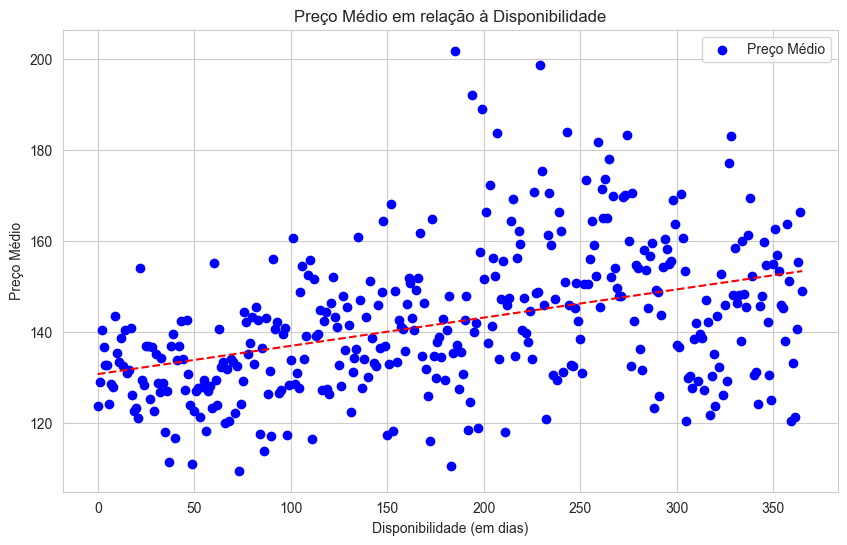

In [19]:
#Disponibilidade e Preço

#Seleciona as colunas do DF
preço_disponibilidade = df[['disponibilidade_365','price']]

#Faz o agrupamento
preço_disponibilidade = preço_disponibilidade.groupby(by='disponibilidade_365').mean().reset_index()

#Faz o arredondamento
preço_disponibilidade['price'] = round(preço_disponibilidade['price'],2)

#Faz a correlação entre preço e disponibilidade
correlação = preço_disponibilidade.corr()


#Observação: gráfico criado com auxílio de IA
# Criando o gráfico
plt.figure(figsize=(10, 6))

# Linha de tendência central
x = preço_disponibilidade['disponibilidade_365']
y = preço_disponibilidade['price']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

# Pontos de dados
plt.scatter(preço_disponibilidade['disponibilidade_365'], preço_disponibilidade['price'], color='blue', label='Preço Médio')

# Configurações do gráfico
plt.title('Preço Médio em relação à Disponibilidade')
plt.xlabel('Disponibilidade (em dias)')
plt.ylabel('Preço Médio')
plt.legend()

#Exbibição da Correlação
print("Correlação entre preço e disponibilidade\n")
print(correlação)
print("\n\n")

# Exibindo o gráfico
plt.grid(True)
plt.show()

No que tange o preço médio e o tempo em que anúncio fica disponível para reserva há uma correlação moderada de 0.41.
Quanto maior o preço mais a acomodação fica disponível.

Outras correlações




<Axes: >

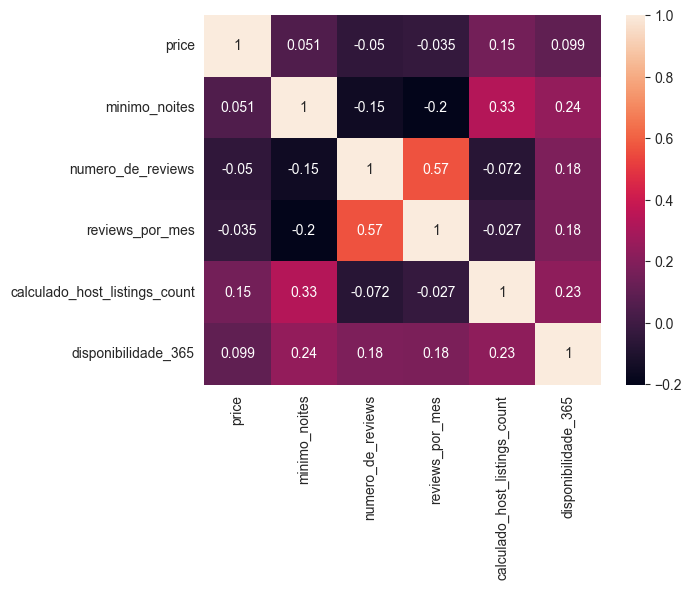

In [20]:
#Outras correlações

#Seleciona a colunas com valores numéricos do DF
teste = df[['price','minimo_noites','numero_de_reviews','reviews_por_mes','calculado_host_listings_count','disponibilidade_365']]

corr = teste.corr()

print("Outras correlações\n\n")
sns.heatmap(corr, annot=True, )

De forma geral os coeficientes de correlação são fracos, com exceção da correlação de número_reviews e reviews por mês, que apresenta uma correlação moderada de 0.549

2 - a) Manhattan é o grupo de bairros mais indicado para se investir em um imóvel para alugar na plataforma. Com base nos dados analisados até agora Manhattan apresenta o maior ticket médio de preço e a maior ocupação ao longo do ano. Essa estratégia tem se mostrado frutífera uma vez que os maiores anunciantes se concetram em Manhattan e em sua maioria alugamm casa/apartamento.

2 - b) Conforme já visto da etapa de EDA, há uma tendência geral de queda de preço em relação ao mínimo de noites. No que tange o preço médio e a disponibilidade há uma tendência de aumento de preço quanto maior for o período em que o  anúncio fica disponível. Pode-se deduzir que imóveis mais caros ficam mais tempo sendo anunciados e que imóveis mais baratos tem uma aceitação maior.

O padrão das palavras que mais se repetem nos anúncios do 1% mais caro são:


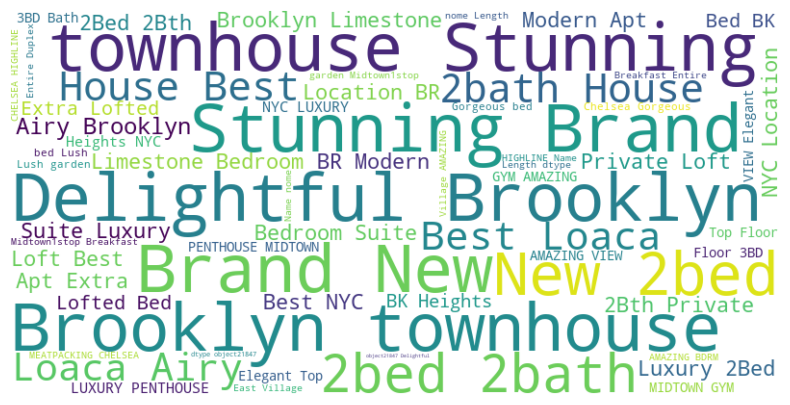

In [21]:
#2 - c) As palavras mais 

#Cria o df que será usado na nuvem
df_nuvem = df[['nome','price']].copy()
#Ordena a nuvem com base no preço
df_nuvem = df_nuvem.sort_values(by='price', ascending=False)



#Calcula o tamanho do 1% dos anúncios mais caros
um_porcento = len(df_nuvem)*0.01
#converte para inteiro
um_porcento = int(um_porcento)

#Mantém no DF só o 1% mais caro
df_nuvem = df_nuvem[:um_porcento]


#Converte para string
df_nuvem['nome'] = str(df_nuvem['nome'])


#Junta as frases em uma única frase
texto_nuvem = "".join(df_nuvem['nome'])

#Gera a nuvem
nuvem_palavras = WordCloud(width=800, height=400, background_color='white').generate(texto_nuvem)

#Exibe a nuvem
plt.figure(figsize=(10, 5))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis('off')

print("O padrão das palavras que mais se repetem nos anúncios do 1% mais caro são:")

plt.show()

#3

#Método 

Por se tratar da previsão de uma variável NUMÉRICA o problema pode ser melhor resolvido utilizando uma regressão.
A classificação é melhor indicada quando o foco é uma variável categórica.


#Tranformações

Por serem particular a cada anúncio e não agregarem nos cálculos as variáveis 'id', 'nome' e 'host_name' foram descartas para realizar a previsão.
A remoção de outliers utilizada foi a mesma aplicada na etapa de EDA.
Considerando que o algoritmo trabalha com valores numéricos as variáveis 'bairro_group','bairro' e 'room_type' foram convertidas para números inteiros utilizando a função LabelEncoder


#Modelo

Em razão do meu pouco conhecimento de modelos de regressão optei por utilizar a biblioteca Pycarot. Essa biblioteca testa diversos algoritmos e indica qual melhor se adapta ao conjunto de dados. O Light Gradient Boosting Machine foi indicado como a melhor opção, mas como não tenho familiaridade com esse modelo optei por utilizar a Regressão Multipla.


#Performance

A medida de performance escolhida foi a R2 pois ela é a mais indicada para apontar a qualidade do modelo em relação ao valor original e a previsão. Seu valor de 0 a 1 indica o quanto o modelo está acertando.



In [22]:
#4

#Importa as bibliotecas
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from pycaret.regression import *


#Carrega o CSV
df = pd.read_csv('teste_indicium_precificacao.csv')


#Filtra os outliers. São os mesmos comandos utilizados no EDA
df = df[(df['price'] <= 600) & (df['price'] != 0)]
df = df[df['minimo_noites'] <= 30]

Como os meus conhecimentos em algortimos de ML são limitados eu optei por utilizar a biblioteca Pycarot para selecionar qual seria o melhor modelo.
A biblioteca Pcarot é uma ferramenta de AutoML onde diversos algoritmos são testados e os resultados são medidos, indicando qual é o melhor algoritmo.

In [23]:
#Carrega as colunas do DF
modeldf = df[['bairro', 'bairro_group', 'latitude', 'longitude', 'room_type', 'price', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']].copy()

#Faz o setup do Pycarot. Em target foi indicado que o valor a ser previsto
setup(modeldf, target='price')

#Faz as comparações entre os modelos
compare_models()

,Description,Value
0,Session id,4817
1,Target,price
2,Target type,Regression
3,Original data shape,"(47389, 11)"
4,Transformed data shape,"(47389, 17)"
5,Transformed train set shape,"(33172, 17)"
6,Transformed test set shape,"(14217, 17)"
7,Numeric features,7
8,Categorical features,3
9,Rows with missing values,19.9%


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,42.1003,4358.8135,66.0109,0.5106,0.3909,0.3449,0.2380
xgboost,Extreme Gradient Boosting,42.8949,4457.4311,66.7481,0.4996,0.4030,0.3534,0.2700
rf,Random Forest Regressor,43.1140,4531.5261,67.3038,0.4912,0.3997,0.3545,6.4510
gbr,Gradient Boosting Regressor,43.3442,4557.1706,67.5001,0.4884,0.4009,0.3573,1.8260
et,Extra Trees Regressor,43.5504,4662.2363,68.2625,0.4766,0.4048,0.3570,3.2680
lr,Linear Regression,46.6772,5024.0514,70.8753,0.4360,0.4524,0.3928,0.4520
ridge,Ridge Regression,46.6727,5024.1099,70.8757,0.4360,0.4519,0.3927,0.0830
lar,Least Angle Regression,46.6772,5024.0514,70.8753,0.4360,0.4524,0.3928,0.0840
br,Bayesian Ridge,46.6650,5024.3740,70.8776,0.4359,0.4512,0.3926,0.0960
llar,Lasso Least Angle Regression,46.9401,5089.0124,71.3318,0.4287,0.4481,0.4024,0.0830


LGBMRegressor(n_jobs=-1, random_state=4817)

O Pycarot indica que o melhor algoritmo para esse dataset é o Light Gradient Boosting Machine.
Devido a minha pouca familiaridade com esse algoritmo não foi possível usa-lo.
Estudando na W3 School pude observar que a Regressão Múltipla seria adequada uma vez que o preço (variável dependente) será formada a partir de múltiplas variáveis independentes.


In [24]:
#Seleciona as colunas que serão usadas
modeldf = df[['id','bairro', 'bairro_group', 'latitude', 'longitude', 'room_type', 'price', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']].copy()


#Como a regressão não permite valores NaN a função fillna irá preenche-los com a mediana
modeldf['reviews_por_mes'] = modeldf['reviews_por_mes'].fillna(modeldf['reviews_por_mes'].median())
modeldf['disponibilidade_365'] = modeldf['disponibilidade_365'].fillna(modeldf['disponibilidade_365'].median())

In [25]:

#Converte valores categóricos para númericos
label_encoder = LabelEncoder()

modeldf['bairro_group'] = label_encoder.fit_transform(modeldf['bairro_group'])
modeldf['bairro'] = label_encoder.fit_transform(modeldf['bairro'])
modeldf['room_type'] = label_encoder.fit_transform(modeldf['room_type'])


# X = variáveis independentes
# y = variável dependente que será prevista
X = modeldf[['bairro', 'bairro_group', 'latitude', 'longitude', 'room_type', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']]
y = modeldf['price']

#Treino do modelo
regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression()

In [26]:
#Esse comando é só para criar o .pkl e não precisa ser executado o EDA e o modelo de regressão

#Cria um arquivo chamado 'Modelo de Regressão.pkl' na mesma pasta em que está localizado esse .ipynt
#pickle.dump(regr, open('Modelo de Regressão.pkl', 'wb'))

In [27]:
#Vai percorrer toda a variável modeldf para encontrar em qual linha(índice) está o anúncio 2595.

i=0

while(i<=len(modeldf)):
    if modeldf['id'].iloc[i] == 2595:
        índice = i
        print("o anúncio está na posição",i)
        break
    i = i +1
    
#Descarta a coluna ID para que ela não seja utilizada na regressão
modeldf.drop(columns='id',inplace=True)


o anúncio está na posição 0


In [28]:
#Faz a previsão dos preços dos dados
predicted_price = regr.predict(modeldf[['bairro', 'bairro_group', 'latitude', 'longitude', 'room_type', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']])

#Calcula o R2
r2 = r2_score(y, predicted_price)


#Exibição de dados
print("Coeficiente de Determinação R2 é de", round(r2,4))
print(f"O preço previsto para o anúncio 2595 é de {round(predicted_price[índice],2)} reais")

Coeficiente de Determinação R2 é de 0.3691
O preço previsto para o anúncio 2595 é de 228.62 reais
